# **Text Mining Group Project 23-24**

## **Group 3**

**Elements**:
- Afonso Gorjão | 20230575 | 20230575@novaims.unl.pt
- Diogo Almeida | 20230737 | 20230737@novaims.unl.pt
- Frederico Portela | R20181072 | r20181072@novaims.unl.pt
- Pedro Carvalho | 20230554 | 20230554@novaims.unl.pt

**Index**
* [1. Library imports](#library-imports)
* [2. Constants](#constants)
* [3. Data Imports](#data-imports)
* [4. Data Exploration Before Pre-Processing](#data-exploration-before-preproc)
    * [4.1. High-level statistics](#high-level-stats)
* [5. Data Pre-processing](#data-preprocessing)
* [6. Data Exploration Post Pre-Processing](#data-exploration-post-preproc)
* [7. Feature Engineering](#feature-engineering)
* [8. Model Development](#model-dev)
* [9. Model Comparison](#model-comp)
* [10. Plug-and-play Solution](#plug-n-play)

## **Library Imports**<a id='library-imports'></a>

In [ ]:
!pip install fasttext
!pip install deep-translator
!pip install datasets
!pip install accelerate -U
!pip install keras_preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [38]:
import os
from copy import deepcopy
from collections import defaultdict, Counter
import random
import time
import re
import string
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import nltk
# nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # lexicon-based
from sklearn.model_selection import GridSearchCV
import spacy

from bs4 import BeautifulSoup

import fasttext
from deep_translator import GoogleTranslator  # https://github.com/nidhaloff/deep-translator

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay, confusion_matrix,
                             accuracy_score, f1_score, precision_score, recall_score)


import transformers
from transformers import pipeline
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset, DatasetDict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchtext.vocab as vocab
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.transforms import ToTensor
import torchtext.vocab as vocab

from keras_preprocessing.sequence import pad_sequences

## **Constants**<a id='constants'></a>

In [29]:
SEED = 42

# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# transformers.set_seed(SEED)

RAW_DATA_DIR = os.path.join('corpora', 'raw-data')

TRAIN_INFO_PATH = os.path.join(RAW_DATA_DIR, 'train.xlsx')
TRAIN_REVIEWS_PATH = os.path.join(RAW_DATA_DIR, 'train_reviews.xlsx')

TEST_INFO_PATH = os.path.join(RAW_DATA_DIR, 'test.xlsx')
TEST_REVIEWS_PATH = os.path.join(RAW_DATA_DIR, 'test_reviews.xlsx')

TRAIN_PREPROCESSED_PATH = os.path.join('corpora', 'train_preprocessed.pkl')
TEST_PREPROCESSED_PATH = os.path.join('corpora', 'test_preprocessed.pkl')

TRAIN_PREPROCESSED_PATH_DRIVE = r"C:\Users\Pedro Arons\Desktop\IMS\Text Mining\proj2\corpora\train_preprocessed.pkl"
TEST_PREPROCESSED_PATH_DRIVE = r"C:\Users\Pedro Arons\Desktop\IMS\Text Mining\proj2\corpora\test_preprocessed.pkl"

## **Data Imports**<a id='data-imports'></a>

- **Metadata Class**

In [3]:
class Metadata:

    """
    Easy access to metadata for the Airbnb dataset.
    """

    descriptions = {
        'index': 'index column to identify each property',
        'description': 'property description',
        'host_about': 'host information',
        'unlisted': 'target column: whether the property is unlisted (1) or not (0)',
        'comments': 'guest comments on the property. A property can have multiple or no comments',
    }

    @classmethod
    def describe(cls, column):
        return cls.descriptions[column]

    @classmethod
    def add(cls, name, description):
        cls.descriptions[name] = description


# example
metadata = Metadata()
print(f"Metadata Class example: {metadata.describe('index')}")

Metadata Class example: index column to identify each property


- **Train and Test Imports**

In [4]:
train_info_raw = pd.read_excel(TRAIN_INFO_PATH)
train_reviews_raw = pd.read_excel(TRAIN_REVIEWS_PATH)

print(f'Train info shape: {train_info_raw.shape}')
display(train_info_raw.head())
print(f'\nTrain reviews shape: {train_reviews_raw.shape}')
display(train_reviews_raw.head())

# we might also want to check the test data to ensure compatibility
test_info_raw = pd.read_excel(TEST_INFO_PATH)
test_reviews_raw = pd.read_excel(TEST_REVIEWS_PATH)

print(f'\nTest info shape: {test_info_raw.shape}')
display(test_info_raw.head())
print(f'\nTest reviews shape: {test_reviews_raw.shape}')
display(test_reviews_raw.head())

assert test_info_raw.columns.tolist() == train_info_raw.columns.tolist()[:-1], 'Test and train info columns do not match'
assert test_reviews_raw.columns.tolist() == train_reviews_raw.columns.tolist(), 'Test and train reviews columns do not match'

# time to load: ~30s

Train info shape: (6248, 4)


,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0



Train reviews shape: (361281, 2)


,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."



Test info shape: (695, 3)


,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
3,4,Charming Apartment Close to the Bay of Cascais...,:)
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...



Test reviews shape: (41866, 2)


,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...
3,1,We've been in Lisbon in march 2013 (3 adults a...
4,1,Our host Antonio was very helpful with informa...


- **Making Copies of the Data**

In [5]:
# during exploration we will transform the data
# we want to make them in a copy in order to not
# alter the original data
train_info = train_info_raw.copy()
train_reviews = train_reviews_raw.copy()
test_info = test_info_raw.copy()
test_reviews = test_reviews_raw.copy()

## **Data Exploration Before Pre-Processing**

- **Missing Values**

In [6]:
# there seems to be blank spaces not being identified as nulls
# r'^\s*$' matches strings that are empty or contain only whitespace
# ^ asserts the start of the string
# \s* matches zero or more whitespace characters (spaces, tabs, newlines, etc.)
# $ asserts the end of the string

def replace_pseudo_nans(df):
    new_df = df.replace(r'^\s*$', np.nan, regex=True)
    new_df = new_df.replace('Nan', np.nan)
    new_df = new_df.replace('Nul', np.nan)
    return new_df

In [7]:
print('Before pseudo-nan replacement:')

print('Train info missing values:')
print(train_info.isna().sum())
print('\nTrain reviews missing values:')
print(train_reviews.isna().sum())
print('\nTest info missing values:')
print(test_info.isna().sum())
print('\nTest reviews missing values:')
print(test_reviews.isna().sum())

print('\n--------------------------------\n')
print('After pseudo-nan replacement:')
train_info = replace_pseudo_nans(train_info)
train_reviews = replace_pseudo_nans(train_reviews)
test_info = replace_pseudo_nans(test_info)
test_reviews = replace_pseudo_nans(test_reviews)

print('Train info missing values:')
print(train_info.isna().sum())
print('\nTrain reviews missing values:')
print(train_reviews.isna().sum())
print('\nTest info missing values:')
print(test_info.isna().sum())
print('\nTest reviews missing values:')
print(test_reviews.isna().sum())

# NOTE we are not removing missing values, just highlighting them

Before pseudo-nan replacement:
Train info missing values:
index          0
description    0
host_about     0
unlisted       0
dtype: int64

Train reviews missing values:
index       0
comments    2
dtype: int64

Test info missing values:
index          0
description    0
host_about     0
dtype: int64

Test reviews missing values:
index       0
comments    0
dtype: int64

--------------------------------

After pseudo-nan replacement:
Train info missing values:
index           0
description     0
host_about     24
unlisted        0
dtype: int64

Train reviews missing values:
index       0
comments    4
dtype: int64

Test info missing values:
index          0
description    0
host_about     2
dtype: int64

Test reviews missing values:
index       0
comments    0
dtype: int64


In [ ]:
# ... given that these values are actual missing values the data will be analysed
# as it is AFTER pseudo nan replacement with NaN

- **Duplicates**

In [8]:
# are there duplicates?
print(f'Duplicate rows in train_info: {train_info.duplicated().sum()}')
print(f'Duplicate rows in train_reviews: {train_reviews.duplicated().sum()}')

print(f'\nDuplicate rows in test_info: {test_info.duplicated().sum()}')
print(f'Duplicate rows in test_reviews: {test_reviews.duplicated().sum()}')

# ... duplicate reviews:
print('\nSample of duplicates:')
display(test_reviews[test_reviews.duplicated(keep=False)].head(10))

# removing duplicates (only the reviews dfs have them)
train_reviews = train_reviews.drop_duplicates()
test_reviews = test_reviews.drop_duplicates()

Duplicate rows in train_info: 0
Duplicate rows in train_reviews: 142

Duplicate rows in test_info: 0
Duplicate rows in test_reviews: 15

Sample of duplicates:


,index,comments
1622,42,Great place
1645,42,Great place
8862,155,Good
8884,155,Good
11302,178,Great place!
11416,178,Great location!
11445,178,Great location!
11454,178,Great place!
11631,179,.
11829,179,.


In [ ]:
# ... duplicates shall also be dropped as they provide no information
# on the data

- **High-level Statistics**

In [51]:
# is index unique in train_info?
assert train_info['index'].nunique() == train_info.shape[0], 'Index is not unique'
assert test_info['index'].nunique() == test_info.shape[0], 'Index is not unique'

print(f'Total no. of properties in train dataset: {train_info.shape[0]}')
print(f'Total no. of properties in test dataset: {test_info.shape[0]}')

Total no. of properties in train dataset: 6248
Total no. of properties in test dataset: 695


In [52]:
# are there properties with reviews but without description?
assert set(train_info['index']).issuperset(set(train_reviews['index']))
assert set(test_info['index']).issuperset(set(test_reviews['index']))

# ... all properties in the reviews dfs exist in the info dfs

Unlisted: 1708 (27.34%)
Listed: 4540 (72.66%)



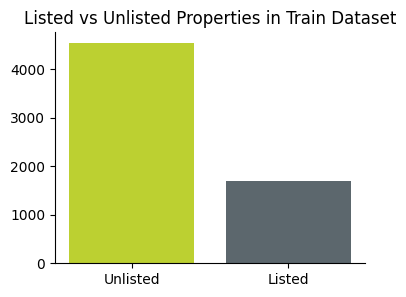

In [59]:
# listed vs unlisted
unlisted_train = train_info['unlisted'].value_counts()
print(f'Unlisted: {unlisted_train[1]} ({unlisted_train[1] / train_info.shape[0] * 100:.2f}%)')
print(f'Listed: {unlisted_train[0]} ({unlisted_train[0] / train_info.shape[0] * 100:.2f}%)\n')

plt.figure(figsize=(4,3))
# Specify the RGB colors for the bars
colors = [(188/255, 208/255, 49/255), (92/255, 103/255, 109/255)]
plt.bar(['Unlisted', 'Listed'], unlisted_train, color=colors)

# Remove the border around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.title('Listed vs Unlisted Properties in Train Dataset')
plt.show()

# ... some data imbalance, might need to address this later

In [9]:
# property reviews

def get_reviews_per_property(info_df, reviews_df, verbose=1):
    reviews_per_property = reviews_df['index'].value_counts()
    total_properties = info_df.shape[0]
    properties_with_reviews = reviews_per_property.shape[0]
    properties_without_reviews = total_properties - properties_with_reviews
    if verbose:
        print(f'Properties with reviews: {properties_with_reviews} ({properties_with_reviews / total_properties * 100:.2f}%)')
        print(f'Properties without reviews: {properties_without_reviews} ({properties_without_reviews / total_properties * 100:.2f}%)')

    if verbose:
        avg_reviews_per_property = reviews_per_property.mean()
        print(f'Average reviews per property: {avg_reviews_per_property:.2f}')
        print(f'Median reviews per property: {reviews_per_property.median():.0f}')
        print(f'Mode of reviews per property: {reviews_per_property.mode()[0]}')
        print(f'Standard deviation of reviews per property: {reviews_per_property.std():.2f}')

    return reviews_per_property

print('Train Dataset:')
reviews_per_property_train = get_reviews_per_property(train_info, train_reviews)

print('\nTest Dataset:')
reviews_per_property_test = get_reviews_per_property(test_info, test_reviews)

# ... maybe, for the properties without reviews we can the most common class?

Train Dataset:
Properties with reviews: 4245 (67.94%)
Properties without reviews: 2003 (32.06%)
Average reviews per property: 85.07
Median reviews per property: 48
Mode of reviews per property: 1
Standard deviation of reviews per property: 96.44

Test Dataset:
Properties with reviews: 475 (68.35%)
Properties without reviews: 220 (31.65%)
Average reviews per property: 88.11
Median reviews per property: 45
Mode of reviews per property: 1
Standard deviation of reviews per property: 102.07


In [60]:
# are there properties with reviews but without host description?
missing_host_about_index = train_info[train_info['host_about'].isnull()]['index'].tolist()
train_reviews.loc[train_reviews['index'].isin(missing_host_about_index) & train_reviews['comments'].notnull(), :].shape

# ... yes, i.e. we can't drop the properties with no host about

(0, 2)

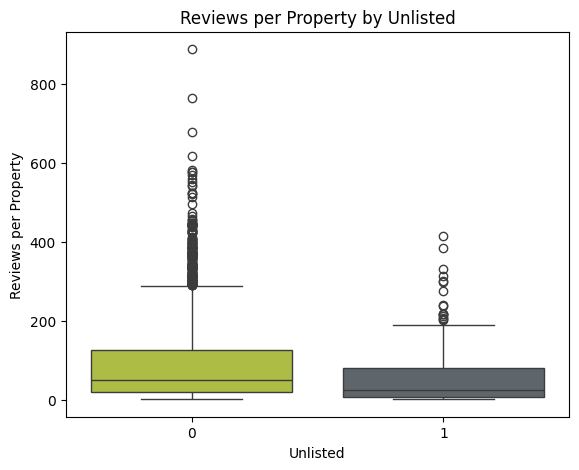

In [106]:
# reviews per property vs. target

def get_label(property_idx, property_df = train_info):
    return property_df.loc[property_df['index'] == property_idx, 'unlisted'].values[0]

property_reviews, property_labels = [], []
for property_idx, nreviews in reviews_per_property_train.items():
    property_reviews.append(nreviews)
    property_labels.append(get_label(property_idx))

plt.figure(figsize=(6.5, 5))
colors = [(188/255, 208/255, 49/255), (92/255, 103/255, 109/255)] 

sns.boxplot(x=property_labels, y=property_reviews, palette=colors)
plt.xlabel('Unlisted')
plt.ylabel('Reviews per Property')
plt.title('Reviews per Property by Unlisted')
plt.show()

# ... there seems to be a slight tendency for houses with more reviews to remain listed

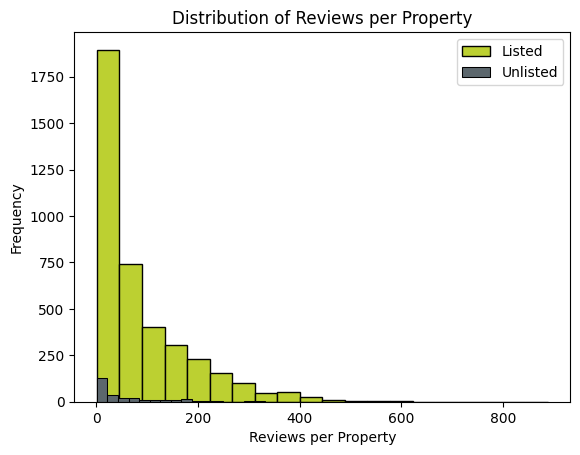

In [114]:
# Separate reviews based on unlisted status
property_reviews_unlisted, property_reviews_listed = [], []
for property_idx, nreviews in reviews_per_property_train.items():
    label = get_label(property_idx)
    if label == 0:
        property_reviews_unlisted.append(nreviews)
    else:
        property_reviews_listed.append(nreviews)

# Create a figure and axis object
fig, ax = plt.subplots()
# Plot distribution for unlisted = 1 (unlisted)
sns.histplot(property_reviews_unlisted, ax=ax, label='Listed', color=(188/255, 208/255, 49/255), alpha=1, bins=20)
# Plot distribution for unlisted = 0 (listed)
sns.histplot(property_reviews_listed, ax=ax, label='Unlisted', color=(92/255, 103/255, 109/255), alpha=1, bins=20)



# Set labels and title
ax.set_xlabel('Reviews per Property')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Reviews per Property')

# Add legend
plt.legend()

# Show plot
plt.show()


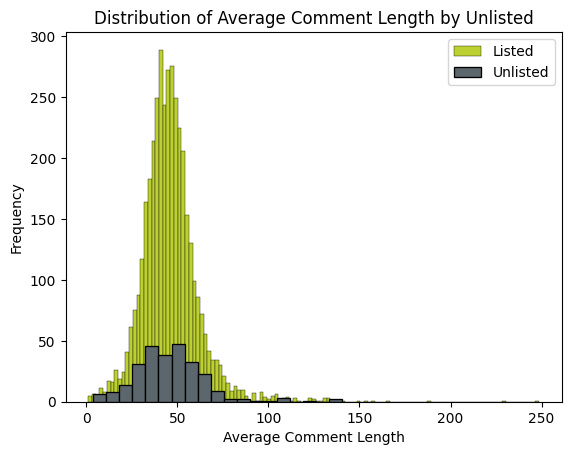

In [115]:
# Merge the two dataframes on 'index'
merged_df = pd.merge(train_info_raw, train_reviews_raw, on='index')

# Calculate comment lengths
merged_df['comments'] = merged_df['comments'].fillna('')
merged_df['avg_comment_length'] = merged_df['comments'].str.split().apply(len)

# Group by 'index' and calculate the mean of 'comment_length' and take the first value of 'unlisted' as it's the same for each group
final_df = merged_df.groupby('index').agg({'unlisted': 'first', 'avg_comment_length': 'mean'}).reset_index()
final_df.set_index('index', inplace=True)
final_df['comment_count'] = merged_df['index'].value_counts()


# Rename columns
final_df = final_df.sort_values(by='index')

unlisted_0 = final_df[final_df['unlisted'] == 0]['avg_comment_length']
unlisted_1 = final_df[final_df['unlisted'] == 1]['avg_comment_length']

# Create a figure and axis object
fig, ax = plt.subplots()
# Plot distribution for unlisted = 0
sns.histplot(unlisted_0, ax=ax, label='Listed', color=(188/255, 208/255, 49/255), alpha=1)
# Plot distribution for unlisted = 1
sns.histplot(unlisted_1, ax=ax, label='Unlisted', color=(92/255, 103/255, 109/255), alpha=1)





# Set labels and title
ax.set_xlabel('Average Comment Length')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Average Comment Length by Unlisted')

# Add legend
plt.legend()

# Show plot
plt.show()





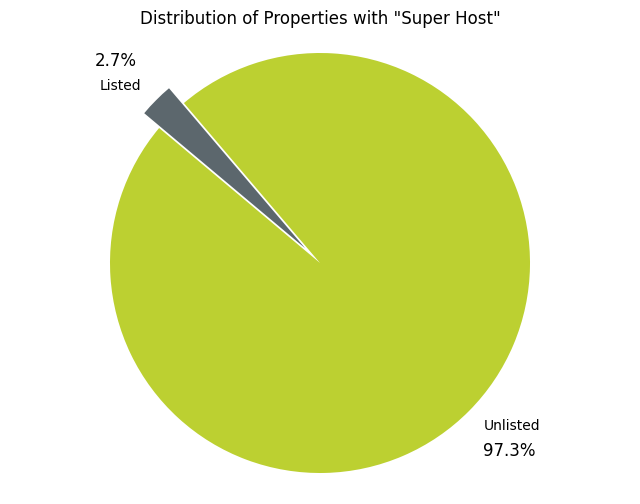

In [150]:
filtered_df = merged_df[merged_df['comments'].str.contains("super host", case=False) | merged_df['description'].str.contains("super host", case=False) | merged_df['host_about'].str.contains("super host", case=False)]
unique_indices_with_superhost = filtered_df['index'].unique()
filtered_train_info = train_info_raw[train_info_raw['index'].isin(unique_indices_with_superhost)]

# Calculate the percentages for 'unlisted' column with super host
percentage_0 = (filtered_train_info['unlisted'].value_counts(normalize=True) * 100).get(0, 0)
percentage_1 = (filtered_train_info['unlisted'].value_counts(normalize=True) * 100).get(1, 0)

# Create labels for the pie chart
labels = ['Unlisted', 'Listed']
sizes = [percentage_0, percentage_1]
colors = [(188/255, 208/255, 49/255), (92/255, 103/255, 109/255)] 
explode = (0.1, 0) 

# Create pie chart
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                                   shadow=False, startangle=140, textprops=dict(color="black"),
                                   pctdistance=1.27)  

# Set percentages as text annotations outside the pie chart
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')

plt.title('Distribution of Properties with "Super Host"')

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Show pie chart
plt.show()


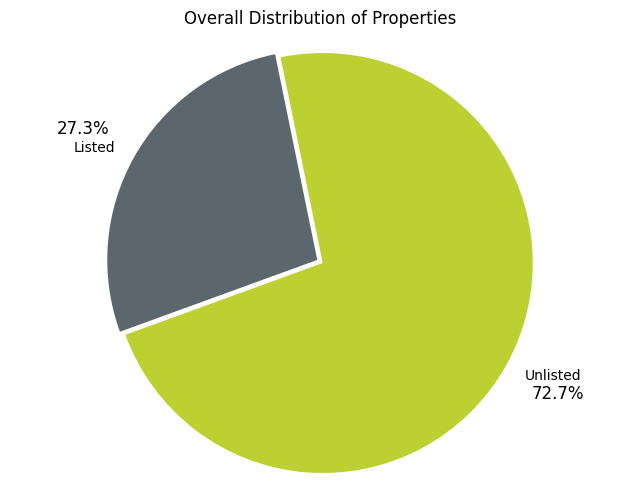

In [157]:
# Calculate the percentages for 'unlisted' column with super host
overall_percentage_0 = (train_info_raw['unlisted'].value_counts(normalize=True) * 100).get(0, 0)
overall_percentage_1 = (train_info_raw['unlisted'].value_counts(normalize=True) * 100).get(1, 0)


# Create labels for the pie chart
labels = ['Unlisted', 'Listed']
sizes = [overall_percentage_0, overall_percentage_1]
colors = [(188/255, 208/255, 49/255), (92/255, 103/255, 109/255)] 
explode = (0.03, 0)  

# Create pie chart
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                                   shadow=False, startangle=200, textprops=dict(color="black"),
                                   pctdistance=1.28)  

# Set percentages as text annotations outside the pie chart
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')

plt.title('Overall Distribution of Properties')

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Show pie chart
plt.show()


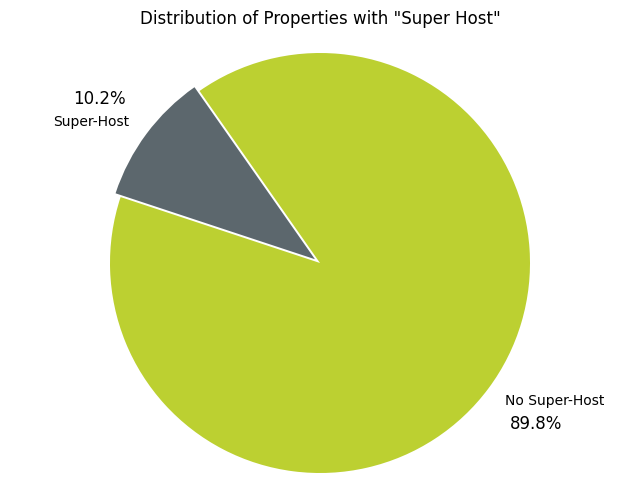

In [178]:
superhost_count = filtered_train_info.shape[0]

# Step 3: Calculate the total number of rows
total_rows = train_info_raw.shape[0]

# Step 4: Calculate the percentage of houses with "super host"
percentage_superhost = (superhost_count / total_rows) * 100


# Create labels for the pie chart
labels = ['Super-Host', 'No Super-Host']
sizes = [percentage_superhost, 100-percentage_superhost]
colors = [(92/255, 103/255, 109/255),(188/255, 208/255, 49/255)] 
explode = (0.03, 0)  

# Create pie chart
plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                                   shadow=False, startangle=125, textprops=dict(color="black"),
                                   pctdistance=1.28)  

# Set percentages as text annotations outside the pie chart
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')

plt.title('Distribution of Properties with "Super Host"')

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Show pie chart
plt.show()

## **Data Pre-Processing**

In [ ]:
# the idea here is to merge the info and reviews datasets and then, iteratively, add new columns
# these new columns will be pre processed versions of the original columns
# e.g. comments -> clean_comments -> no_stopwords_clean_comments -> lemma_no_stopwords_clean_comments
# the names of the columns indicate all the transformations the original column has been through to get there

In [10]:
# storing a copy of the data before cleaning for easier comparison
# between pre and post cleaning

# (no harm in assigninig new data to existing variables as they will be used no more)
train_info = train_info_raw.copy()
train_reviews = train_reviews_raw.copy()
test_info = test_info_raw.copy()
test_reviews = test_reviews_raw.copy()

- **Merging Info with Reviews Datasets**

In [11]:
# merging both train datasets
train_merged = train_info_raw.merge(train_reviews_raw,
                                    on='index',
                                    how='left')

# merging both test sets
test_merged = test_info_raw.merge(test_reviews_raw,
                                  on='index',
                                  how='left')

# making sure all is good for both merged datasets
assert set(train_merged['index'].unique().tolist()) == set(train_info_raw['index'].unique().tolist() + train_reviews_raw['index'].unique().tolist()), 'Missing indexes in train_merged'
assert set(test_merged['index'].unique().tolist()) == set(test_info_raw['index'].unique().tolist() + test_reviews_raw['index'].unique().tolist()), 'Missing indexes in test_merged'

print(f'Train merged shape: {train_merged.shape}')
print(f'Test merged shape: {test_merged.shape}')

Train merged shape: (363284, 5)
Test merged shape: (42086, 4)


- **Dropping Duplicates**

In [12]:
# needs to be done before reindexing
print(f'Duplicates in train_merged: {train_merged.duplicated().sum()} -> dropped')
print(f'Duplicates in test_merged: {test_merged.duplicated().sum()} -> dropped')

train_merged = train_merged.drop_duplicates()
test_merged = test_merged.drop_duplicates()

Duplicates in train_merged: 142 -> dropped
Duplicates in test_merged: 15 -> dropped


- **Reindexing**

In [13]:
# we can ensure the quality of the following transformations
# by creating new indexes - property index and review index

train_merged = train_merged.rename(columns={'index': 'property_index'})
test_merged = test_merged.rename(columns={'index': 'property_index'})

train_merged = train_merged.reset_index().rename(columns={'index': 'comment_index'})
test_merged = test_merged.reset_index().rename(columns={'index': 'comment_index'})

display(train_merged.head(3))

,comment_index,property_index,description,host_about,unlisted,comments
0,0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,this is a very cozy and comfortable house to s...
1,1,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,good<br/>
2,2,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,"My first hostel experience, and all I have to ..."


- **Replace Pseudo-NaNs**

In [14]:
train_merged = replace_pseudo_nans(train_merged)
test_merged = replace_pseudo_nans(test_merged)

print('Missing values in train_merged:')
print(train_merged.isna().sum())
print('\nMissing values in test_merged:')
print(test_merged.isna().sum())

Missing values in train_merged:
comment_index        0
property_index       0
description          0
host_about        1029
unlisted             0
comments          2007
dtype: int64

Missing values in test_merged:
comment_index       0
property_index      0
description         0
host_about        133
comments          220
dtype: int64


- **Custom Transformations**

In [15]:
# one host about description is written in several different languages
# we discovered it by accident. Since it is troublesome to write a function
# that can accurately and quickly discover duplicate sentences in different
# languages we will fix this one by hand. There may be other still to be found.

# this particular instance was found because it exceeds 5000 characters and the
# deep_translator translator class does not allow for sentences bigger than that

train_merged.loc[train_merged['property_index'] == 2245, 'host_about'] = """Travel is life ! I love meeting people and helping them discover the amazing places I am lucky enough to call home in Portugal, Malta and the UK.  Maybe you will do as I did in 2009 and give up your old life to make one of these magical places home...
When travelling, I believe that paying to stay in a place is a real treat, and when you do so the very least that you should expect is for it to be as comfortable and clean as your own home, if not even better.
For me, that means spaces that not only look amazing, but also cover the basics that are so often missing in AirBNB properties such as huge beds with fine linens and 100% blackout for a great nights sleep, plus Air Conditioning and Luxury amenities.
It's these simple luxuries, plus sparkling clean places, great wifi / smart home tech and fast responsive service that I make sure to provide for my guests."""

- **Text Cleaning with Regex and Common String Methods**

In [ ]:
# cleaning functions
# NOTE some of this functions will be used for data pre processing!

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text(separator=" ")
    return cleaned_text


def replace_newlines(text):
    text = text.replace('\n', '')
    return text


def remove_emojis_and_special_characters(text):
    # Regex to remove emojis and non-ASCII characters
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text


def remove_control_characters(text):
    # Remove common problematic sequences
    text = text.replace('_x000D_', '')  # Explicitly replace carriage returns (often used to indicate line breaks)
    # Remove non-printable characters
    text = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', text)
    return text


def remove_or_replace_mentions(text):
    # '@' seems to be either used as a simplification of the word 'at'
    # or a mention. Therefore, if '@' is not attached to any other characters
    # then we will replace it with 'at', else will remove it as well as the
    # characters glued to it.
    if '@' in text:
        text = re.sub(r' @ ', ' at ', text)
        text = re.sub(r'@(\w+)', '', text)
    return text


def remove_urls(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    return text


def remove_or_replace_hashtags(text):
    # not sure if they are really used as hashtags
    # but rather to mean 'number'/'best', e.g. # 1 spot in town!
    if '#1' or '# 1':
        text = re.sub(r'#\s?\b1\b', 'best', text)
    text = re.sub(r'#(\w+)', '', text)
    return text


def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text


def remove_double_withspaces(text):
    # the previous transformations might end up
    # creating duplicate whitespaces
    text = re.sub(r'\s+', ' ', text)
    return text


def remove_functional_punctuation(text):
    # text = re.sub(r'[.,;:()!?\[\]{}]-', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.replace('—', '')
    text = text.replace('’', '')
    text = text.replace('…', '')  # another edge case found
    return text


def lower_case(text):
    return text.lower()


def strip(text):
    return text.strip()

In [ ]:
# function chainer
# select which cleaning functions to use

def clean_text(text):
    # skip nans
    if pd.isna(text):
        return text

    # the order matters
    text = remove_html_tags(text)
    text = replace_newlines(text)
    text = remove_control_characters(text)
    text = remove_or_replace_mentions(text)
    text = remove_urls(text)
    text = remove_or_replace_hashtags(text)
    text = remove_emojis_and_special_characters(text)
    text = remove_functional_punctuation(text)
    text = remove_numbers(text)
    text = remove_double_withspaces(text)
    text = lower_case(text)
    text = strip(text)

    return text

In [ ]:
# testing the cleaning functions
print(clean_text('.'))
print(clean_text('-'))
print(clean_text('—-'))
print(clean_text('drama…'))
print(clean_text('find me at https://my.info.com'))
print(clean_text('Família_x000D_\nPortugal_x000D_'))
print(clean_text('@ZMPoppe\n'))
print(clean_text('me and my friend were @ the cafe'))
print(clean_text('good<br/>'))
print(clean_text('Отличное расположение. Есть всё необходимое. Чисто, уютно. Есть утюг и фен, кофе чай'))
print(clean_text('一个完美的房子体验，非常干净和安静，房东非常热情，离老城区景点非常近，不能错过的房源 '))
print(clean_text('👍 top'))
print(clean_text('   great!!!   '))
print(clean_text('진짜 깔끔하고 있을거 다 구비되어 있습니다. 화장실 깔끔하게 온수도 잘 나오고 물빠짐도 좋아요..'))

In [ ]:
# with the outer merge the columns description and host about are mainly composed of
# duplicate captions. To increase efficiency we can run the pre proc functions for their
# unique values and then map them to them to the merged datasets

def map_from_unique(df, func, text_col, lang_col = None, index='property_index') -> dict:
    # this assumes that data pre processing functions always follow the structure
    # foo(text, lang) or just foo(text), otherwise will return an error

    if lang_col:
        # to the format: {index: (text, lang)}
        unique = pd.Series(df[[text_col, lang_col]].values.tolist(), index=df[index]).map(tuple).to_dict()
        return {index: func(text, lang) for index, (text, lang) in unique.items()}

    # to the format {index: text}
    unique = dict(zip(df[index], df[text_col]))
    return {index: func(text) for index, text in unique.items()}

In [ ]:
start = time.perf_counter()

for df in [train_merged, test_merged]:
    df['clean_description'] = df['property_index'].map(map_from_unique(df, clean_text, 'description'))
    df['clean_host_about'] = df['property_index'].map(map_from_unique(df, clean_text, 'host_about'))
    df['clean_comments'] = df['comments'].apply(clean_text)

print(f'Took {time.perf_counter() - start:0.2f} seconds')

In [ ]:
# cleaning functions that transform text data will end up in generating pseudo nans values
# i.e. empty strings. We need to take this into account

# there are comments like '.' which after being clean an empty string is returned
# these are considered pseudo-nans and need to be replaced with nans

train_merged = train_merged.replace('', np.nan)
test_merged = test_merged.replace('', np.nan)

print('Missing values in train_merged:')
print(train_merged.isna().sum())
print('\nMissing values in test_merged:')
print(test_merged.isna().sum())

- **Handling Missing Values**

In [ ]:
# there is a considerable amount of properties without reviews so removing them would make us lose possibly
# important information. a solution to this is: add new index columns for the position of missing values and
# then replace the actual missing values with some default strings like 'unknown'

# the majority of missing values are in the comments feature. Since the airbnb
# reviews are optional, the lack of reviews might indicate the values to be MNAR
# i.e. a missing value indicates that the client did not want to leave a review.
# On the other hand host information is mandatory and the values are likely MCAR.
# Since both are independent we should avoid imputing these cases with techniques such as KNN.

# NOTE: there are only missing values in host_about and comments columns
# also, all missing values in the clean columns are a superset of the
# missing values of the non-cleaned columns

for df in [train_merged, test_merged]:
    # creating idx columns
    df['nan_index_comments'] = df['clean_comments'].apply(lambda x: 1 if pd.isna(x) else 0)
    df['nan_index_host_about'] = df['clean_host_about'].apply(lambda x: 1 if pd.isna(x) else 0)

    # filling nans
    df['comments'] = df['comments'].fillna('unknown')
    df['clean_comments'] = df['clean_comments'].fillna('unknown')
    df['host_about'] = df['host_about'].fillna('unknown')
    df['clean_host_about'] = df['clean_host_about'].fillna('unknown')

- **Language Detection**

In [ ]:
# using the fasttext library, developed by Facebook, to help detect language
# of text fields it is much faster than other libraries like langdetect

# how to:
# 1. go to: https://fasttext.cc/docs/en/language-identification.html
# 2. download lid.176.ftz and place it in the language-detection folder (if you have no such folder, create it beforehand)
# example: https://huggingface.co/facebook/fasttext-language-identification

class LanguageDetector:
    def __init__(self):
        self.model = self._load_model()

    def _load_model(self):
        model = fasttext.load_model(os.path.join('language-detection', 'lid.176.ftz'))
        return model

    def detect_language(self, text):
        if pd.isna(text):
            return text
        return self.model.predict(text)[0][0].split('__')[-1]

In [ ]:
# class created during data exploration

start = time.perf_counter()

language_detector = LanguageDetector()

for df in [train_merged, test_merged]:
    df['clean_description_lang'] = df['property_index'].map(map_from_unique(df, language_detector.detect_language, 'clean_description'))
    df['clean_host_about_lang'] = df['property_index'].map(map_from_unique(df, language_detector.detect_language, 'clean_host_about'))
    df['clean_comments_lang'] = df['clean_comments'].apply(lambda text: language_detector.detect_language(text))

print(f'Took {time.perf_counter() - start:0.2f} seconds')

In [ ]:
# we are plotting this here and not aftwerwards during data exploration after pre processing
# because this data is used for the next step - we need to check the most common languages
# so we can translate those

description_languages = train_merged[['property_index', 'clean_description_lang']].drop_duplicates()['clean_description_lang'].value_counts()
host_about_languages = train_merged[['property_index', 'clean_host_about_lang']].drop_duplicates()['clean_host_about_lang'].value_counts()
comments_languages = train_merged['clean_comments_lang'].value_counts()

print(f"No. of unique languages in clean_description_lang: {len(description_languages)}")
print(f"No. of unique languages in clean_host_about_lang: {len(host_about_languages)}")
print(f"No. of unique languages in clean_comments_lang: {len(comments_languages)}")

# plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6))

ax1.bar(description_languages.index, description_languages)
ax1.set_title("Unique languages in the 'clean_descriptions' feature")

ax2.bar(host_about_languages.index, host_about_languages)
ax2.set_title("Unique languages in the 'clean_host_about' feature")

ax3.bar(comments_languages.index, comments_languages)
ax3.set_title("Unique languages in the 'clean_comments' feature")

plt.tight_layout()
plt.show()

In [ ]:
common_languages = [
    'en', 'pt', 'es', 'fr',
    'it', 'de', 'nl', 'ru'
]

print(f"Proportion of common languages in comments: {len(train_merged.loc[train_merged['clean_comments_lang'].isin(common_languages)]) / len(train_merged['clean_comments_lang']):.3f}")

# ... ideally we could choose the top 10 languages instead of top 8
# however finding stop words for chinese and korean is troublesome
# therefore we decided on translating them as well
print('\nComments by language:')
print(train_merged['clean_comments_lang'].value_counts()[:15])

In [ ]:
print(f"Null languages: {train_merged['clean_comments_lang'].isnull().sum()}")
assert all(train_merged['clean_comments_lang'].isnull() == train_merged['clean_comments'].isnull()), 'Nulls not at the same indexes'

In [ ]:
# ... and on the test set?

- **Additional #1: Translating Rare Languages**

In [ ]:
# the reviews are written in several different languages. Although ideally our dataset should only
# have text in one unique language, translating all comments to english would be a too time consuming
# task and could as well result in the addition of bias due to information being 'lost in translation'.
# Therefore we picked out the most common languages which will be kept as they are, but will translate to english,
# all other uncommon languages.

# The main reason for the translation is that the resulting languages (after translating rare to en)
# are all supported by libraries for pre processing, like nltk and spacy and pre trained models we use for
# fine tuning and feature extraction were train in a corpous with those languages (at least). Also by translating
# languages we are reducing our vocabulary size which might be helpful for feature engineering.

# although this is an additional step we chose to insert it in the middle of data pre processing because
# cleaning the text data too thouroughly might imply the loss of semantic context and therefore imply
# the lack of quality of the translation

# although this is an additional step, we chose to add it in between the mandatory steps
# because the order matters. Applying the NER spacy algorithm to sentences after being
# heavily pre processed, e.g. stop word removal and lemmatization, might imply the loss
# of context and consequently the lack of accuracy of the NER algorithm

In [ ]:
# for translating we are using the deep_translator library. In essence we are calling
# the google translator API

# quick fixes beforehand
# 'he' is code for 'hebrew'
# but for the deep_translator library it is: 'iw'
# same idea for the others ...

iso_code_fixes = {
    'he': 'iw',  # iw is the old code for hebrew
    'zh': 'zh-CN',  # simplified chinese
}

for df in [train_merged, test_merged]:
    for col_name in ['clean_description_lang', 'clean_host_about_lang', 'clean_comments_lang']:
        df[col_name] = df[col_name].replace(iso_code_fixes)

In [ ]:
# remaining languages
remaining_languages = train_merged.loc[-train_merged['clean_comments_lang'].isin(common_languages), 'clean_comments_lang']
remaining_languages.value_counts()

In [ ]:
# not all languages are supporte by deep_translator

deep_translator_supported = ['af', 'sq', 'am', 'ar', 'hy', 'as', 'ay', 'az', 'bm', 'eu', 'be', 'bn', 'bho', 'bs', 'bg', 'ca', 'ceb', 'ny', 'zh-CN', 'zh-TW',
                             'co', 'hr', 'cs', 'da', 'dv', 'doi', 'nl', 'en', 'eo', 'et', 'ee', 'tl', 'fi', 'fr', 'fy', 'gl', 'ka', 'de', 'el', 'gn', 'gu',
                             'ht', 'ha', 'haw', 'iw', 'hi', 'hmn', 'hu', 'is', 'ig', 'ilo', 'id', 'ga', 'it', 'ja', 'jw', 'kn', 'kk', 'km', 'rw', 'gom', 'ko',
                             'kri', 'ku', 'ckb', 'ky', 'lo', 'la', 'lv', 'ln', 'lt', 'lg', 'lb', 'mk', 'mai', 'mg', 'ms', 'ml', 'mt', 'mi', 'mr', 'mni-Mtei',
                             'lus', 'mn', 'my', 'ne', 'no', 'or', 'om', 'ps', 'fa', 'pl', 'pt', 'pa', 'qu', 'ro', 'ru', 'sm', 'sa', 'gd', 'nso', 'sr', 'st',
                             'sn', 'sd', 'si', 'sk', 'sl', 'so', 'es', 'su', 'sw', 'sv', 'tg', 'ta', 'tt', 'te', 'th', 'ti', 'ts', 'tr', 'tk', 'ak', 'uk', 'ur',
                             'ug', 'uz', 'vi', 'cy', 'xh', 'yi', 'yo', 'zu']


deep_unsupported_languages = []
for lang, comment_count in zip(remaining_languages.value_counts().index, remaining_languages.value_counts().values):
     if lang not in deep_translator_supported:
         deep_unsupported_languages.append(lang)
         print(f'{lang}: {comment_count}')

In [ ]:
# the unsupported languages represent such a minuscule amount of data that they can
# be removed without any major implications
# we just need to make sure there is no property that only has reviews in one of those languages
# to avoid messing up the output excel file (test predictions)

for idx, row in test_merged.groupby('property_index').agg({'clean_comments_lang': lambda x: x.tolist()}).reset_index().iterrows():
    if len(row['clean_comments_lang']) == 1:
        if row['clean_comments_lang'][0] in deep_unsupported_languages:
            print(f'WARNING: {idx}, {row}')

# ... no printed statement ==> there won't be no issues, we can remove them safely

train_merged = train_merged.loc[-train_merged['clean_comments_lang'].isin(deep_unsupported_languages), :]
test_merged = test_merged.loc[-test_merged['clean_comments_lang'].isin(deep_unsupported_languages), :]

In [ ]:
# if we group first by language then we only
# need to call GoogleTranslator once for each language
# i.e. faster
def group_by_language(df, lang_col_name):
    u_lang = df[lang_col_name].unique()
    for lang in u_lang:
        df_lang = df.loc[df[lang_col_name] == lang, :]
        yield df_lang


def apply_translation(df, text_col_name, lang_col_name, df_index_col):
    df_lang_gen = group_by_language(df, lang_col_name)
    new_df = pd.DataFrame()
    for df_lang in df_lang_gen:
        # every df only contains rows of the same language
        lang = df_lang[lang_col_name].iloc[0]

        if lang not in common_languages:
            # NOTE: max translation length of 5000 characters
            # NOTE: some languages are not accepted
            translator = GoogleTranslator(source=lang, target='en')
            translated_text = []
            for text in tqdm(df_lang[text_col_name], total=len(df_lang), desc=f'Translating {text_col_name} {lang} to en'):
                # translation upper cases words and adds punctuation
                # we need to remove them
                translated_text.append(remove_functional_punctuation(translator.translate(text).lower()))
            df_lang[f'trans_{text_col_name}'] = translated_text
        else:
            # else, keep as is
            df_lang[f'trans_{text_col_name}'] = df_lang[text_col_name]

        # final
        new_df = pd.concat([new_df, df_lang], axis=0)

    return new_df


start = time.perf_counter()
for df in [train_merged, test_merged]:
    for text_col in ['clean_description', 'clean_host_about', 'clean_comments']:

        # need to do this due to the mapping function
        if (text_col == 'clean_description') or (text_col == 'clean_host_about'):
            index_col = 'property_index'
        else:
            index_col = 'comment_index'

        lang_col = f'{text_col}_lang'
        reduced_df = df[[index_col, text_col, lang_col]].drop_duplicates()
        trans_df = apply_translation(reduced_df, text_col, lang_col, index_col)
        df[f'trans_{text_col}'] = df[index_col].map(dict(zip(trans_df[index_col], trans_df[f'trans_{text_col}'])))
        df[f'trans_{lang_col}'] = df[lang_col].apply(lambda x: 'en' if x not in common_languages else x)

print(f'Took {time.perf_counter() - start:0.2f} seconds')

In [ ]:
# checking if all is good
train_merged['trans_clean_comments_lang'].value_counts()

- **Additional #2: Named Entity Recognition (NER)**

In [ ]:
# although this is an additional step, we chose to add it in between the mandatory steps
# because the order matters. Applying the NER spacy algorithm to sentences after being
# heavily pre processed, e.g. stop word removal and lemmatization, might imply the loss
# of context and consequently the lack of accuracy of the NER algorithm

# firstly you need to download the pre-trained spacy models:
# python -m spacy download <model name, e.g. en_core_web_sm>
# for all models in the dictionary below
# NOTE: spacy 'sm' models are built for efficiency whereas 'trf' models are built for accuracy

# the common languages
spacy_nlp_models = {
    'en': spacy.load('en_core_web_sm'),
    'pt': spacy.load('pt_core_news_sm'),
    'fr': spacy.load('fr_core_news_sm'),
    'it': spacy.load('it_core_news_sm'),
    'es': spacy.load('es_core_news_sm'),
    'de': spacy.load('de_core_news_sm'),
    'nl': spacy.load('nl_core_news_sm'),
    'ru': spacy.load('ru_core_news_sm')
}

In [ ]:
# the spacy model is somewhat complex so in order to increase efficiency
# we can use the pipe method: https://spacy.io/usage/processing-pipelines

# https://www.kaggle.com/code/curiousprogrammer/entity-extraction-and-classification-using-spacy
# spacy recognizes the following entities
# PERSON - People, including fictional.
# NORP - Nationalities or religious or political groups.
# FAC - Buildings, airports, highways, bridges, etc.
# ORG - Companies, agencies, institutions, etc.
# GPE - Countries, cities, states.
# LOC - Non-GPE locations, mountain ranges, bodies of water.
# PRODUCT - Objects, vehicles, foods, etc. (Not services.)
# EVENT - Named hurricanes, battles, wars, sports events, etc.
# WORK_OF_ART - Titles of books, songs, etc.
# LAW - Named documents made into laws.
# LANGUAGE - Any named language.
# DATE - Absolute or relative dates or periods.
# TIME - Times smaller than a day.
# PERCENT - Percentage, including "%".
# MONEY - Monetary values, including unit.
# QUANTITY - Measurements, as of weight or distance.
# ORDINAL - "first", "second", etc.
# CARDINAL - Numerals that do not fall under another type.


def ner(df, text_col_name, lang_col_name, actions, df_index_col):

    def act(doc, lang):
        # the NER are not necessarily tokens, e.g. tokens ['optimus', 'prime']
        # and NER 'PERSON' -> 'Optimus Prime', so this is not about replacing
        # tokens with the entity but replacing substrings with the entity
        text = doc.text
        for ent in doc.ents:
            # print(ent.text, ent.label_)
            ent_label = ent.label_
            ent_text = ent.text
            if ent_label in actions.keys():
                text = text.replace(ent_text, actions[ent_label][lang] if not None else '')
        return text

    disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]  # for efficiency reasons
    df_lang_gen = group_by_language(df, lang_col_name)  # using data generator to group datasets by language to speed up nlp.pipe
    new_df = pd.DataFrame()
    for df_lang in df_lang_gen:
        lang = df_lang[lang_col_name].iloc[0]
        new_col = []
        for doc in tqdm(spacy_nlp_models[lang].pipe(df_lang[text_col_name].tolist(), disable=disable), total=len(df_lang), desc=f'NER {text_col_name} [{lang}]'):
            # print([(ent.text, ent.label_) for ent in doc.ents])
            text = act(doc, lang)
            new_col.append(text)

        # creating new column
        df_lang[f'ner_{text_col_name}'] = new_col

        # final
        new_df = pd.concat([new_df, df_lang], axis=0)

    return new_df


# if value is None then that entity will be removed
# if str then will be replaced by that string
ner_actions = {
    'PERSON': {'en': 'person', 'pt': 'pessoa', 'fr': 'personne', 'es': 'persona', 'it': 'personne', 'de': 'person', 'nl': 'persoon', 'ru': 'человек'},
    'GPE': {'en': 'location', 'pt': 'local', 'fr': 'emplacement', 'es': 'ubicación', 'it': 'posizione', 'de': 'standort', 'nl': 'plaats', 'ru': 'расположение'},
    'LOC': {'en': 'location', 'pt': 'local', 'fr': 'emplacement', 'es': 'ubicación', 'it': 'posizione', 'de': 'standort', 'nl': 'plaats', 'ru': 'расположение'},
}
# ... we could but no, we are not removing anything

start = time.perf_counter()

for df in [train_merged, test_merged]:
    for text_col in ['trans_clean_description', 'trans_clean_host_about', 'trans_clean_comments']:

        if (text_col == 'trans_clean_description') or (text_col == 'trans_clean_host_about'):
            index_col = 'property_index'
        else:
            index_col = 'comment_index'

        lang_col_name = f'{text_col}_lang'
        reduced_df = df[[index_col, text_col, lang_col_name]].drop_duplicates()
        ner_df = ner(reduced_df, text_col, lang_col_name, ner_actions, index_col)
        df[f'ner_{text_col}'] = df[index_col].map(dict(zip(ner_df[index_col], ner_df[f'ner_{text_col}'])))

print(f'Took {time.perf_counter() - start:0.2f} seconds')

In [ ]:
# NER does have its short comings
train_merged[['trans_clean_comments', 'ner_trans_clean_comments']].sample(10)

# ... seems to not be working more often than it does

# LIMITATIONS:
# ... too much cleaning beforehand
# ... the unrigorous / informal grammar and ortography in reviews

# ... but note that although it may not always increase the quality
# of the text it does not seem to decrease it, i.e. replace non-entities
# (we basically have various False Negatives - not picking up on entities -
# but few, if any, False Positives)

- **Removing Stop Words**

In [ ]:
# transforming it into ISO 639-1 codes
nltk_stopwords = {
    'nl': stopwords.words('dutch'),
    'en': stopwords.words('english'),
    'fr': stopwords.words('french'),
    'de': stopwords.words('german'),
    'it': stopwords.words('italian'),
    'pt': stopwords.words('portuguese'),
    'ru': stopwords.words('russian'),
}

In [ ]:
def remove_stopwords(text, lang='en'):
    if lang in nltk_stopwords.keys():
        text = ' '.join([t for t in word_tokenize(text) if t not in nltk_stopwords[lang]])
    return text


start = time.perf_counter()

for df in [train_merged, test_merged]:
    for text_col in ['trans_clean_description', 'trans_clean_host_about', 'trans_clean_comments']:
        lang_col = f'{text_col}_lang'
        ner_col = f'ner_{text_col}'

        if (text_col == 'trans_clean_description') or (text_col == 'trans_clean_host_about'):
            # without NER
            df[f'no_stopwords_{text_col}'] = df['property_index'].map(map_from_unique(df, remove_stopwords, text_col, lang_col))
            # with NER
            df[f'no_stopwords_{ner_col}'] = df['property_index'].map(map_from_unique(df, remove_stopwords, ner_col, lang_col))
        else:
            # without NER
            df[f'no_stopwords_{text_col}'] = df.apply(lambda row: remove_stopwords(row[text_col], row[lang_col]), axis=1)
            # with NER
            df[f'no_stopwords_{ner_col}'] = df.apply(lambda row: remove_stopwords(row[ner_col], row[lang_col]), axis=1)

print(f'Took {time.perf_counter() - start:0.2f} seconds')

In [ ]:
# example of how stop word removal might return a blank string

train_merged.loc[train_merged['no_stopwords_trans_clean_comments'] == '', ['comments', 'trans_clean_comments', 'no_stopwords_trans_clean_comments']].sample(10)

# ... new examples of pseudo nans
# ... text cleaning might not always be perfect

In [ ]:
# stopwords removal migth strip a string untils its blank
print((train_merged == '').sum())
print()
print((test_merged == '').sum())

In [ ]:
# add to nan_index and replace blanks with the 'unknown' token

def update_nan_index(nan_index, text):
    if nan_index == 1:
        return 1
    elif (text == 'nan') or (pd.isna(text)):
        return 1
    else:
        return 0

for df in [train_merged, test_merged]:
    for text_col in ['no_stopwords_trans_clean_host_about', 'no_stopwords_ner_trans_clean_host_about', 'no_stopwords_trans_clean_comments', 'no_stopwords_ner_trans_clean_comments']:
        # creating idx columns
        df['nan_index_comments'] = df.apply(lambda row: update_nan_index(row['nan_index_comments'], row[text_col]), axis=1)
        df[text_col] = df[text_col].replace('', 'unknown')

- **Stemming**

In [ ]:
nltk_stemmers = {
    'nl': SnowballStemmer('dutch'),
    'en': SnowballStemmer('english'),
    'fr': SnowballStemmer('french'),
    'de': SnowballStemmer('german'),
    'it': SnowballStemmer('italian'),
    'pt': SnowballStemmer('portuguese'),
    'es': SnowballStemmer('spanish'),
    'ru': SnowballStemmer('russian'),
}

In [ ]:
def stem(text, lang):
    if lang in nltk_stemmers.keys():
        stemmer = nltk_stemmers[lang]
        text = ' '.join([stemmer.stem(t) for t in word_tokenize(text)])
    return text


start = time.perf_counter()

for df in [train_merged, test_merged]:
    for text_col in ['trans_clean_description', 'trans_clean_host_about', 'trans_clean_comments']:
        lang_col = f'{text_col}_lang'
        ner_col = f'ner_{text_col}'

        if (text_col == 'trans_clean_description') or (text_col == 'trans_clean_host_about'):
            # without NER
            df[f'stem_no_stopwords_{text_col}'] = df['property_index'].map(map_from_unique(df, stem, f'no_stopwords_{text_col}', lang_col))
            # with NER
            df[f'stem_no_stopwords_{ner_col}'] = df['property_index'].map(map_from_unique(df, stem, f'no_stopwords_{ner_col}', lang_col))
        else:
            # without NER
            df[f'stem_no_stopwords_{text_col}'] = df.apply(lambda row: stem(row[f'no_stopwords_{text_col}'], row[lang_col]), axis=1)
            # with NER
            df[f'stem_no_stopwords_{ner_col}'] = df.apply(lambda row: stem(row[f'no_stopwords_{ner_col}'], row[lang_col]), axis=1)

print(f'Took {time.perf_counter() - start:0.2f} seconds')

- **Lemmatization**

In [ ]:
def lemmatize(df, text_col_name, lang_col_name):

    disable=['parser','ner']  # for efficiency reasons
    df_lang_gen = group_by_language(df, lang_col_name)  # using data generator to group datasets by language to speed up nlp.pipe
    new_df = pd.DataFrame()
    for df_lang in df_lang_gen:
        lang = df_lang[lang_col_name].iloc[0]
        new_col = []
        for doc in tqdm(spacy_nlp_models[lang].pipe(df_lang[text_col_name].tolist(), disable=disable), total=len(df_lang), desc=f'Lemmatizing {text_col_name} [{lang}]'):
            text = " ".join([token.lemma_ for token in doc])
            new_col.append(text)

        # creating new column
        df_lang[f'lemma_{text_col_name}'] = new_col

        # final
        new_df = pd.concat([new_df, df_lang], axis=0)

    return new_df


start = time.perf_counter()

# also with and without NER
columns = [
    'no_stopwords_trans_clean_description',
    'no_stopwords_trans_clean_host_about',
    'no_stopwords_trans_clean_comments',
    'no_stopwords_ner_trans_clean_description',
    'no_stopwords_ner_trans_clean_host_about',
    'no_stopwords_ner_trans_clean_comments',
]

for df in [train_merged, test_merged]:
    for text_col in columns:

        if ('description' in text_col) or ('host_about' in text_col):
            index_col = 'property_index'
        else:
            index_col = 'comment_index'

        lang_col_name = f"{text_col.replace('no_stopwords_', '').replace('ner_', '')}_lang"
        reduced_df = df[[index_col, text_col, lang_col_name]].drop_duplicates()
        lemma_df = lemmatize(reduced_df, text_col, lang_col_name)
        df[f'lemma_{text_col}'] = df[index_col].map(dict(zip(lemma_df[index_col], lemma_df[f'lemma_{text_col}'])))

print(f'Took {time.perf_counter() - start:0.2f} seconds')

In [ ]:
# other probably useful pre processing techniques:

# topic modelling

# replacement of rare words by an UNK token (would decrease the size of the vocab. and therefore of the model parameters however
# we would need to define the thresholds manually for what is considered a rare word: this processed is made more difficult due
# to the existence of several languages, e.g. underrepresented languages could have all its vocb. removed)

# remove short comments (e.g. < 3 words)

# pre clean before NER (basically everything except punctuation removal?), apply NER, and then finish cleaning

- **Saving Pre-Processed Datasets**

In [ ]:
# ALL PRE PROCESSING STEPS APPLIED

# 1. merger of train and test's info and reviews datafranes, resulting in train_merged and test_merged
# 2. reindexed dataframes, 'index' was replaced by 'property_index' and then the real index was reset and renamed to 'comment_index' (this name is somewhat misleading as there are properties without comments and therefore it would make more sense to name it 'row_index' or similar)
# 3. replaced pseudo NaNs with real NaNs (things like blanks, 'null' or 'nan' strings)
# 4. Dropped duplicates
# 5. Custom transformations: only one, a host_about string, which was in several languages. We only encountered this issue because the text was longer than 5k characters which raised an error when calling the GoogleTranslator translate method, of the deep_translator library.
# 6. Text cleaning with regular expressions and common string methods, e.g. emoji, html tags, punctuation, hastags, mentions removal and text lowering, between others.
# 7. Initial missing value handling (major step of MV removal although not the only one), removal of comments and replacement of host_about.
# 8. Language detection with fasttext
# 9. Additional #1: Translating rare languages.
# 	9.1. iso code fixes
# 	9.2. removal of comments written in unsupported languages for translation
# 	9.3. translation
# 10. Additional #2: Named entity recognition: replaced entities with default words, e.g. Person or location
# 11. Stop word removal
# 	11.1. removal
# 	11.2. there were some comments which only contained a random set of characters and some were classified as stopwords and by removing them we were left with an empty string. These rows were dropped.
# 12. Stemming - applied to both NER and non-NER rows
# 13. Lemmatization - same as above
# 14. We were left with a new dataset with lots of new columns. These datasets were exported to csvs.

In [ ]:
train_merged.to_pickle(os.path.join('corpora', 'train_preprocessed.pkl'))
test_merged.to_pickle(os.path.join('corpora', 'test_preprocessed.pkl'))

## **Data Exploration After Pre Processing**

- **Importing Pre Processed Data**

In [19]:
# keep in mind that the pre processed datasets contain all transformations history meaning
# we can source from the same ds the same column before and after any transformation

def load_preprocessed_data(columns=None, *, train_path, test_path):

    train_df = pd.read_pickle(train_path)
    test_df = pd.read_pickle(test_path)

    if columns:

        if isinstance(columns, str):
            columns = [columns]

        # just making sure that the columns are in the dataset
        columns_train = list(set(columns + ['property_index', 'unlisted']))
        columns_test = list(set(columns + ['property_index']))

        train_df = train_df[columns_train]
        test_df = test_df[columns_test]

    return train_df, test_df


def groupby_property(df):

    for col in df.columns:
        if ('index' in col) and (col != 'property_index'):
            df.drop(col, axis=1, inplace=True)

    if 'comment_index' in df.columns:
        df = df.drop('comment_index', axis=1)

    unlisted_exists = False
    if 'unlisted' in df.columns:
        unlisted_exists = True
        label_dict = {property_id: label for property_id, label in zip(df['property_index'], df['unlisted'])}
        df = df.drop('unlisted', axis=1)  # otherwise groupby would return error -> ''.join([ints...]) raises TypeError

    new_df = df.groupby('property_index').agg(lambda x: ' '.join(set(x))).reset_index()

    if unlisted_exists:
        new_df['unlisted'] = new_df['property_index'].map(label_dict)

    return new_df

In [20]:
# loading all columns
# train_clean, test_clean = load_preprocessed_data()
train_clean, test_clean = load_preprocessed_data(train_path=TRAIN_PREPROCESSED_PATH_DRIVE, test_path=TEST_PREPROCESSED_PATH_DRIVE)
print(f'Pre-processed train shape: {train_clean.shape}')
print(f'Pre-processed test shape: {test_clean.shape}')

Pre-processed train shape: (363117, 41)
Pre-processed test shape: (42070, 40)


In [21]:
# grouping by property index
grouped_train_clean = groupby_property(train_clean)
grouped_test_clean = groupby_property(test_clean)
print(f'Grouped pre-processed train shape: {grouped_train_clean.shape}')
print(f'Groupped pre-processed test shape: {grouped_test_clean.shape}')

Grouped pre-processed train shape: (6248, 38)
Groupped pre-processed test shape: (695, 37)


- **Word Count**

In [ ]:
word_columns = [
    ('comments', 'trans_clean_comments', 'no_stopwords_ner_trans_clean_comments'),
    ('description', 'trans_clean_description', 'no_stopwords_ner_trans_clean_description'),
    ('host_about', 'trans_clean_host_about', 'no_stopwords_ner_trans_clean_host_about'),
]

# every tuple needs to have the same size!

In [ ]:
def word_counter(text):
    if pd.isna(text):
        return 0
    return len(text.split())

for cols in word_columns:
    word_counts = []
    for col in cols:
        word_count = train_clean[col].drop_duplicates().map(word_counter)
        word_counts.append(word_count)

    fig, axes = plt.subplots(len(word_counts), 1, figsize=(10, 8), sharex=True)

    if len(word_counts) == 1:
        axes = [axes]

    for ax, word_count in zip(axes, word_counts):
        ax.hist(word_count, bins=30)
        ax.set_title(f"Word count distribution of the '{col}' feature")

    plt.tight_layout()
    plt.show()

- **Word Cloud**

In [ ]:
def generate_joint_text(column_data):
    return ' '.join([text for text in column_data if not pd.isna(text)])

for cols in word_columns:
    joint_texts = []
    for col in cols:
        joint_text = generate_joint_text(train_clean[col].drop_duplicates())
        joint_texts.append(joint_text)

    wordclouds = [(col, WordCloud(width=800, height=400, background_color="white").generate(joint_text))
                  for col, joint_text in zip(cols, joint_texts)]

    fig, axes = plt.subplots(len(wordclouds), 1, figsize=(10, 8 * len(wordclouds)))

    if len(wordclouds) == 1:
        axes = [axes]

    for ax, (col, wordcloud) in zip(axes, wordclouds):
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Word Cloud for '{col}'")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

- **N-Grams**

In [ ]:
# ... n-grams?

- **Sentiment Analysis**

In [ ]:
# there are basically 3 types of sentiment analysis:
# 1. lexicon-based
# 2. machine learning-based
# 3. pre-trained transformer-based deep learning

In [47]:
# speeding up process by selecting sample of english comments

train_clean_sentiment = train_clean.loc[train_clean['trans_clean_comments_lang'] == 'en', :]
print(train_clean_sentiment.shape)

(243022, 38)


In [ ]:
model_ckpt = 'xlm-roberta-base'
device = ("cuda" if torch.cuda.is_available() else "cpu")
sentiment_analysis = sentiment_analysis = pipeline('sentiment-analysis', model=model_ckpt, tokenizer=model_ckpt,
                                                   max_length=512, truncation=True, device=device)

# NOTE using train clean instead of grouped as the concatenation of reviews

start = time.perf_counter()

sentiment_scores = {}
for col in ['ner_trans_clean_description', 'ner_trans_clean_host_about', 'ner_trans_clean_comments', ]:
    df = train_clean_sentiment[[col, 'unlisted']].drop_duplicates()
    print(f"Analyzing {col} ({df.shape})...")
    sentiment = sentiment_analysis(df[col].tolist())
    sentiment_scores[col] = {'scores': [sent['score'] for sent in sentiment], 'labels': df['unlisted'].tolist()}

print(f'Took {time.perf_counter() - start:0.2f} seconds')

In [ ]:
# chi-square test for independence
# H0: There is no significant relationship between Variable A and Variable B.
# vs.
# H1: There is a significant relationship between Variable A and Variable B
# therefore, rejecting the null suggests that there is evidence of an
# association between the variables.


for col, scores in sentiment_scores.items():
    contingency_table = pd.crosstab(scores['scores'], scores['labels'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(col)
    print("Chi-square statistic:", chi2)
    print("p-value:", p)
    # print("Degrees of freedom:", dof)
    # print("Expected frequencies:")
    # print(expected)
    print(f"Conclusion: {'Reject' if p < 0.05 else 'Fail to reject'} the null.")
    print('\n---------------------------------------------\n')

In [ ]:
# limitations
# ... english observations might not be representative of the whole data
# ... data cleaning / processing might cause bias
# ... reviews might put out mixed signals, e.g. bad review about property, positive reiew
#     about trip, 'apartment was awful but the city was mesmerizing', model might predict
#     positive sentiment.
# ... lack of accuracy of the sentiment analyser used
# ... lack of power of the chi-square test

## **Train-Validation-Test Split**

In [22]:
# due to sheer amount of data k-fold cross-validation will not be feasible
# so a train-val-test split is preferred

def two_step_proportions(train_p, val_p, test_p):
    """
    Since we need to split the data in two steps
    this function returns the proportions of the
    'test_size' arg. needed to get the true prop.
    """
    return (test_p, 1-(train_p/(1-test_p)))


def stratified_train_val_test_split(X, y, proportions=(.8, .1, .1)):

    test_size_1, test_size_2 = two_step_proportions(*proportions)

    X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                                y,
                                                                test_size=test_size_1,
                                                                shuffle=True,
                                                                stratify=y,
                                                                random_state=SEED)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                      y_train_val,
                                                      test_size=test_size_2,
                                                      shuffle=True,
                                                      stratify=y_train_val,
                                                      random_state=SEED)

    return (X_train, X_val, X_test, y_train, y_val, y_test)

In [50]:
import numpy as np

# Sample data
X = np.random.rand(1000, 10)
y = np.random.randint(0, 2, 1000)

# Split data
proportions = (0.8, 0.1, 0.1)
X_train, X_val, X_test, y_train, y_val, y_test = stratified_train_val_test_split(X, y, proportions)

# Check proportions
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Check stratification
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Validation set class distribution: {np.bincount(y_val)}")
print(f"Test set class distribution: {np.bincount(y_test)}")


Training set size: 800
Validation set size: 100
Test set size: 100
Training set class distribution: [387 413]
Validation set class distribution: [48 52]
Test set class distribution: [48 52]


## **Feature Engineering**<a id='feature-engineering'></a>

In [ ]:
# not even going to try TF-IDF due to multi languages - TF-IDF weights the importance of words
# based on their frequency in a document relative to the entire corpus, and since we have various
# languages the importance of a word would be affected by its the proportion of the la

# also due to multi-languages an approach like BoW would be sub-par since its issues
# like curse of dim. would only be exponentiated.

In [ ]:
# TODO we can checkout new types of tokenization

#### **Word2Vec - Skip-Gram**

In [ ]:
# Define necessary functions
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens


def build_training(tokenized_corpus, word2idx, window_size=2):
    idx_pairs = []

    for sentence in tokenized_corpus:
        indices = [word2idx[word] for word in sentence]
        for center_word_pos in range(len(indices)):
            for w in range(-window_size, window_size + 1):
                context_word_pos = center_word_pos + w
                if  context_word_pos < 0 or \
                    context_word_pos >= len(indices) or \
                    center_word_pos == context_word_pos:
                    continue
                context_word_idx = indices[context_word_pos]
                idx_pairs.append((indices[center_word_pos], context_word_idx))

    return np.array(idx_pairs)


def get_onehot_vector(word_idx, vocabulary):
    x = torch.zeros(len(vocabulary)).float()
    x[word_idx] = 1.0
    return x


def Skip_Gram(training_pairs, vocabulary, embedding_dims=5, learning_rate=0.001, epochs=10):
    # input layer will have the size of the vocab
    # the output layer will also have the size of the vocab
    # the hidden layer will have as many dimensions and the embedding dims

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    W1 = torch.randn(embedding_dims, len(vocabulary), requires_grad=True).float().to(device)
    W2 = torch.randn(len(vocabulary), embedding_dims, requires_grad=True).float().to(device)

    losses = []

    for epo in range(epochs):
        loss_val = 0

        for input_word, target in tqdm(training_pairs, desc=f'Epoch {epo}', total=len(training_pairs)):
            x = get_onehot_vector(input_word, vocabulary).float().to(device)
            y_true = torch.from_numpy(np.array([target])).long().to(device)

            # Zero the gradients
            W1.grad = None
            W2.grad = None

            # Matrix multiplication to obtain the input word embedding
            z1 = torch.matmul(W1, x)

            # Matrix multiplication to obtain the z score for each word
            z2 = torch.matmul(W2, z1)

            # Apply Log and softmax functions
            log_softmax = F.log_softmax(z2, dim=0)  # Applies a softmax followed by a logarithm.

            # Compute the negative-log-likelihood loss
            loss = F.nll_loss(log_softmax.view(1, -1), y_true)  # .view -> Returns a tensor with the same data but with a different shape.
            loss_val += loss.item()  # .item -> Returns the value of this tensor as a standard Python number.

            # Compute the gradient in function of the error
            loss.backward()

            # Check if gradients have been computed
            if W1.grad is not None and W2.grad is not None:
                # Update your embeddings
                with torch.no_grad():
                    W1 -= learning_rate * W1.grad
                    W2 -= learning_rate * W2.grad
                    W1.grad.zero_()
                    W2.grad.zero_()

            # .grad -> This attribute is None by default and becomes a Tensor the first time a call to backward()
            #computes gradients. The attribute will then contain the gradients computed and future
            #calls to backward() will accumulate (add) gradients into it.

        losses.append(loss_val/len(training_pairs))

    return W1, W2, losses


def get_document_embedding(doc, word2idx, W1):
    indices = [word2idx[word] for word in doc if word in word2idx]
    if len(indices) == 0:
        return np.zeros(W1.shape[0])
    embeddings = W1[:, indices]
    doc_embedding = embeddings.mean(dim=1).detach().numpy()
    return doc_embedding


def plot_loss(loss):
    x_axis = [epoch+1 for epoch in range(len(loss))]
    plt.plot(x_axis, loss, '-g', linewidth=1, label='Train')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

In [ ]:
# example usage
# 1. import pre processed data
train_df, test_df = load_preprocessed_data(columns=['property_index', 'lemma_no_stopwords_ner_trans_clean_comments', 'trans_clean_comments_lang'],
                                           train_path=TRAIN_PREPROCESSED_PATH_DRIVE, test_path=TEST_PREPROCESSED_PATH_DRIVE)

# 1.1.
# due to size of vocab. we need to only keep reviews in one language!!
train_df = train_df.loc[train_df['trans_clean_comments_lang'] == 'en', :]
test_df = test_df.loc[test_df['trans_clean_comments_lang'] == 'en', :]
train_df = train_df.drop('trans_clean_comments_lang', axis=1)
test_df = test_df.drop('trans_clean_comments_lang', axis=1)

# 2. group data by property
grouped_train_df = groupby_property(train_df)
grouped_test_df = groupby_property(test_df)

# 3. train-val-test split
X = np.array(grouped_train_df['lemma_no_stopwords_ner_trans_clean_comments'])
y = np.array(grouped_train_df['unlisted'])
X_train, X_val, X_test, y_train, y_val, y_test = stratified_train_val_test_split(X, y)

In [ ]:
# 4. tokenize corpus
X_train_tokenized = tokenize_corpus(X_train)
X_val_tokenized = tokenize_corpus(X_val)
X_test_tokenized = tokenize_corpus(X_test)

In [ ]:
# 5. get word indexes
words_X_train = set(word for sentence in X_train_tokenized for word in sentence)
word2idx_X_train = {word: idx for idx, word in enumerate(words_X_train)}

# 6. build training pairs
training_pairs = build_training(X_train_tokenized, word2idx_X_train, window_size=2)

In [ ]:
# 7. Train the skip-gram model
embedding_dims = 30
learning_rate = 0.001
epochs = 3

W1, W2, losses = Skip_Gram(training_pairs, word2idx_X_train, embedding_dims, learning_rate, epochs)

# TODO even by just choosing enlish this stuff takes too much time (>24hrs).
# we can either:
# ... only keep english or other popular language
# ... remove rare words
# ... use pre trained word2vec (gensim)

In [ ]:
# 8. get feature vectors
feature_vectors_X_train = [get_document_embedding(doc, word2idx_X_train, W1) for doc in X_train_tokenized]
feature_vectors_X_val = [get_document_embedding(doc, word2idx_X_train, W1) for doc in X_val_tokenized]
feature_vectors_X_test = [get_document_embedding(doc, word2idx_X_train, W1) for doc in X_test_tokenized]

# TODO make sentence embedding otherwise we will get MEMORY ERRORS

In [ ]:
# 9. making data ingestible
X_train = torch.tensor(feature_vectors_X_train, dtype=torch.float32)
X_val = torch.tensor(feature_vectors_X_val, dtype=torch.float32)
X_test = torch.tensor(feature_vectors_X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
# using pre trained model:
print(list(gensim.downloader.info()['models'].keys()))

In [ ]:
class W2V:
    def __init__(self, name):
        self.name = name
        self.w2v = gensim.downloader.load(self.name)
        self.emb_dim = int(self.name.split('-')[-1])

    def _corpus2vec(self, corpus):
        corpus_vec = []
        for document in tqdm(corpus, total=len(corpus), desc='Getting embeddings'):
            doc_vectors = []
            for word in document.split():
                if word in self.w2v.index_to_key:
                    doc_vectors.append(self.w2v.get_vector(word))
            doc_vectors = np.mean(np.array(doc_vectors), axis=0)  # getting sentence embeddings
            corpus_vec.append(doc_vectors)
        return corpus_vec

    def get_sentence_embeddings(self, corpus):
        corpus_vec = self._corpus2vec(corpus)
        return corpus_vec


w2v_name = 'word2vec-google-news-300'  # 300 means the embedding size is 3 hundred
w2v = W2V(w2v_name)
X_train_w2v = w2v.get_sentence_embeddings(X_train)
X_val_w2v = w2v.get_sentence_embeddings(X_val)
X_test_w2v = w2v.get_sentence_embeddings(X_test)

# ... also takes a lot of time... (>4hrs)

#### **GloVe**

- **GloVe Class**

In [40]:
class ExtractGloVe:
    def __init__(self, name, dim, cache_dir=None):
        self.name = name
        self.dim = dim
        self.cache_dir = cache_dir

        if cache_dir:
            self.glove = vocab.GloVe(name=self.name, dim=self.dim, cache=self.cache_dir)
        else:
            self.glove = vocab.GloVe(name=self.name, dim=self.dim)

    def _get_glove_token_embedding(self, word):
        word_idx = self.glove.stoi.get(word)
        print(word_idx)
        if word_idx is None:
            return torch.zeros(self.dim)
        return self.glove.vectors[word_idx]

    def get_sentence_embeddings(self, corpus):
        glove_embeddings = []
        for text in tqdm(corpus, total=len(corpus), desc=f'Extracting GloVe Embeddings ({self.dim})'):
            tokenized_text = text.split()
            text_embeddings = np.mean(np.array([self._get_glove_token_embedding(token) for token in tokenized_text]), axis=0)
            glove_embeddings.append(text_embeddings)
        return np.array(glove_embeddings)

- **Creating Datasets**

In [41]:
def create_glove_datasets(column,
                          model_name,
                          dim,
                          group = True,
                          *,
                          cache_dir = None,
                          train_path=TRAIN_PREPROCESSED_PATH_DRIVE,
                          test_path=TEST_PREPROCESSED_PATH_DRIVE,
                          split_proportions=(.8, .1, .1)):

    # 1. load data
    train_df = load_preprocessed_data(columns=column, train_path=train_path, test_path=test_path)[0]

    # if more than one column is passed, concatenate them
    if isinstance(column, list) and len(column) > 1:

        def concat(*texts):
            return ' '.join(texts)

        train_df['concatenated'] = train_df[[col for col in column]].apply(lambda x: concat(*x), axis=1)
        column = 'concatenated'


    # 2. group by property
    if group:
        train_df = groupby_property(train_df)

    # 3. split
    X = np.array(train_df[column])
    y = np.array(train_df['unlisted'])
    X_train, X_val, X_test, y_train, y_val, y_test = stratified_train_val_test_split(X, y, proportions=split_proportions)

    # 4. get embeddings
    if cache_dir:
        glove = ExtractGloVe(model_name, dim, cache_dir)
    else:
        glove = ExtractGloVe(model_name, dim)
    X_train_glove = glove.get_sentence_embeddings(X_train)
    X_val_glove = glove.get_sentence_embeddings(X_val)
    X_test_glove = glove.get_sentence_embeddings(X_test)

    return X_train_glove, X_val_glove, X_test_glove, y_train, y_val, y_test

In [26]:
TRAIN_PREPROCESSED_PATH_DRIVE = r"C:\Users\Pedro Arons\Desktop\IMS\Text Mining\proj2\corpora\train_preprocessed.pkl"

# Read the pickle file into a DataFrame
df = pd.read_pickle(TRAIN_PREPROCESSED_PATH_DRIVE)

# Display the columns of the DataFrame
print(df.columns)

Index(['comment_index', 'property_index', 'description', 'host_about',
       'unlisted', 'comments', 'clean_description', 'clean_host_about',
       'clean_comments', 'nan_index_comments', 'nan_index_host_about',
       'clean_description_lang', 'clean_host_about_lang',
       'clean_comments_lang', 'trans_clean_description',
       'trans_clean_description_lang', 'trans_clean_host_about',
       'trans_clean_host_about_lang', 'trans_clean_comments',
       'trans_clean_comments_lang', 'ner_trans_clean_description',
       'ner_trans_clean_host_about', 'ner_trans_clean_comments',
       'no_stopwords_trans_clean_description',
       'no_stopwords_ner_trans_clean_description',
       'no_stopwords_trans_clean_host_about',
       'no_stopwords_ner_trans_clean_host_about',
       'no_stopwords_trans_clean_comments',
       'no_stopwords_ner_trans_clean_comments',
       'stem_no_stopwords_trans_clean_description',
       'stem_no_stopwords_ner_trans_clean_description',
       'stem_no_st

In [31]:
glove_datasets = {}
# glove_cache_dir = '/content/drive/MyDrive/.vector_cache'  # only need to if using colab
glove_cache_dir = '.vector_cache'

# dataset 1:
columns = 'lemma_no_stopwords_ner_trans_clean_comments'
glove_name = '6B'
glove_dim = 50  # allows for 50, 100, 200 and 300

X_train_glove_50d, X_val_glove_50d, X_test_glove_50d, y_train_glove_50d, y_val_glove_50d, y_test_glove_50d = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                   cache_dir=glove_cache_dir,
                                                                                                                                   train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                   test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_50d'] = {
    'X_train': X_train_glove_50d,
    'X_val': X_val_glove_50d,
    'X_test': X_test_glove_50d,
    'y_train': y_train_glove_50d,
    'y_val': y_val_glove_50d,
    'y_test': y_test_glove_50d,
}

# dataset 2:
columns = 'lemma_no_stopwords_ner_trans_clean_comments'
glove_name = '6B'
glove_dim = 100

X_train_glove_100d, X_val_glove_100d, X_test_glove_100d, y_train_glove_100d, y_val_glove_100d, y_test_glove_100d = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                         cache_dir=glove_cache_dir,
                                                                                                                                         train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                         test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_100d'] = {
    'X_train': X_train_glove_100d,
    'X_val': X_val_glove_100d,
    'X_test': X_test_glove_100d,
    'y_train': y_train_glove_100d,
    'y_val': y_val_glove_100d,
    'y_test': y_test_glove_100d,
}

# dataset 3:
columns = 'lemma_no_stopwords_ner_trans_clean_comments'
glove_name = '6B'
glove_dim = 200

X_train_glove_200d, X_val_glove_200d, X_test_glove_200d, y_train_glove_200d, y_val_glove_200d, y_test_glove_200d = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                         cache_dir=glove_cache_dir,
                                                                                                                                         train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                         test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_200d'] = {
    'X_train': X_train_glove_200d,
    'X_val': X_val_glove_200d,
    'X_test': X_test_glove_200d,
    'y_train': y_train_glove_200d,
    'y_val': y_val_glove_200d,
    'y_test': y_test_glove_200d,
}

# dataset 4:
columns = 'lemma_no_stopwords_ner_trans_clean_comments'
glove_name = '6B'
glove_dim = 300

X_train_glove_300d, X_val_glove_300d, X_test_glove_300d, y_train_glove_300d, y_val_glove_300d, y_test_glove_300d = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                         cache_dir=glove_cache_dir,
                                                                                                                                         train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                         test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_300d'] = {
    'X_train': X_train_glove_300d,
    'X_val': X_val_glove_300d,
    'X_test': X_test_glove_300d,
    'y_train': y_train_glove_300d,
    'y_val': y_val_glove_300d,
    'y_test': y_test_glove_300d,
}

# dataset 5:
columns = 'lemma_no_stopwords_ner_trans_clean_description'
glove_name = '6B'
glove_dim = 50

X_train_glove_description, X_val_glove_description, X_test_glove_description, y_train_glove_description, y_val_glove_description, y_test_glove_description = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                         cache_dir=glove_cache_dir,
                                                                                                                                         train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                         test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_description'] = {
    'X_train': X_train_glove_description,
    'X_val': X_val_glove_description,
    'X_test': X_test_glove_description,
    'y_train': y_train_glove_description,
    'y_val': y_val_glove_description,
    'y_test': y_test_glove_description,
}

# dataset 6:
columns = ['lemma_no_stopwords_ner_trans_clean_description', 'lemma_no_stopwords_ner_trans_clean_host_about', 'lemma_no_stopwords_ner_trans_clean_comments']
glove_name = '6B'
glove_dim = 50

X_train_glove_concat, X_val_glove_concat, X_test_glove_concat, y_train_glove_concat, y_val_glove_concat, y_test_glove_concat = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                         cache_dir=glove_cache_dir,
                                                                                                                                         train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                         test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_concat'] = {
    'X_train': X_train_glove_concat,
    'X_val': X_val_glove_concat,
    'X_test': X_test_glove_concat,
    'y_train': y_train_glove_concat,
    'y_val': y_val_glove_concat,
    'y_test': y_test_glove_concat,
}


# dataset 7:
'''columns = ['stem_no_stopwords_ner_trans_clean_comments']
glove_name = '6B'
glove_dim = 200

X_train_glove_stem1_200, X_val_glove_stem1_200, X_test_glove_stem1_200, y_train_glove_stem1_200, y_val_glove_stem1_200, y_test_glove_stem1_200 = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                         cache_dir=glove_cache_dir,
                                                                                                                                         train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                         test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_stem1_200'] = {
    'X_train': X_train_glove_stem1_200,
    'X_val': X_val_glove_stem1_200,
    'X_test': X_test_glove_stem1_200,
    'y_train': y_train_glove_stem1_200,
    'y_val': y_val_glove_stem1_200,
    'y_test': y_test_glove_stem1_200,
}

# dataset 8:
columns = ['stem_no_stopwords_trans_clean_comment']
glove_name = '6B'
glove_dim = 200

X_train_glove_stem2_200, X_val_glove_stem2_200, X_test_glove_stem2_200, y_train_glove_stem2_200, y_val_glove_stem2_200, y_test_glove_stem2_200 = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                         cache_dir=glove_cache_dir,
                                                                                                                                         train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                         test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_stem2_200'] = {
    'X_train': X_train_glove_stem2_200,
    'X_val': X_val_glove_stem2_200,
    'X_test': X_test_glove_stem2_200,
    'y_train': y_train_glove_stem2_200,
    'y_val': y_val_glove_stem2_200,
    'y_test': y_test_glove_stem2_200,
}

# dataset 9:
columns = ['no_stopwords_ner_trans_clean_comments']
glove_name = '6B'
glove_dim = 200

X_train_glove_nostem_nolem_200, X_val_glove_nostem_nolem_200, X_test_glove_nostem_nolem_200, y_train_glove_nostem_nolem_200, y_val_glove_nostem_nolem_200, y_test_glove_nostem_nolem_200 = create_glove_datasets(columns, glove_name, glove_dim,
                                                                                                                                         cache_dir=glove_cache_dir,
                                                                                                                                         train_path=TRAIN_PREPROCESSED_PATH,
                                                                                                                                         test_path=TEST_PREPROCESSED_PATH)

glove_datasets['glove_nostem_nolem_200'] = {
    'X_train': X_train_glove_nostem_nolem_200,
    'X_val': X_val_glove_nostem_nolem_200,
    'X_test': X_test_glove_nostem_nolem_200,
    'y_train': y_train_glove_nostem_nolem_200,
    'y_val': y_val_glove_nostem_nolem_200,
    'y_test': y_test_glove_nostem_nolem_200,
}'''

Extracting GloVe Embeddings (200):   0%|          | 0/4998 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'split'

#### **Additional #1: XLM-RoBERTa Embeddings (Feature Extraction)**

- **Feature Extractor Class**

This class will be used for both additional methods.

In [ ]:
# helper function to get data splits
# into usable format
def build_joint_dataset(datasets: list[tuple], split_names=None):
    if split_names is None:
        split_names = ['train', 'validation', 'test'][:len(datasets)]
    joint_dataset = {name: Dataset.from_dict({'text': ds[0], 'label': ds[1]})
                     for name, ds in zip(split_names, datasets)}
    joint_dataset = DatasetDict(joint_dataset)
    return joint_dataset


def untangle_dataset(datasetdict):
    X_train = np.array(datasetdict["train"]["hidden_state"])
    X_val = np.array(datasetdict["validation"]["hidden_state"])
    X_test = np.array(datasetdict["test"]["hidden_state"])
    y_train = np.array(datasetdict["train"]["label"])
    y_val = np.array(datasetdict["validation"]["label"])
    y_test = np.array(datasetdict["test"]["label"])
    return X_train, X_val, X_test, y_train, y_val, y_test


class FeatureExtractor:
    def __init__(self, model_ckpt, data, device=None):
        self.model_ckpt = model_ckpt
        self.data = data
        self.model = AutoModel.from_pretrained(self.model_ckpt)
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_ckpt)
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def _tokenize(self, batch):
        return self.tokenizer(batch['text'], padding="max_length", truncation=True,
                              return_tensors='pt', max_length=128)

    def _extract_hidden_states(self, batch):
        inputs = {k:v.to(self.device) for k,v in batch.items() if k in self.tokenizer.model_input_names}
        with torch.no_grad():
            last_hidden_state = self.model(**inputs).last_hidden_state
        return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

    def get_embeddings(self):
        print('Tokenizing...')
        data_encoded = self.data.map(self._tokenize, batched=True, batch_size=None)
        print('Extracting hidden states...')
        data_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
        data_hidden = data_encoded.map(self._extract_hidden_states, batched=True)
        return data_hidden

In [ ]:
def create_feature_extraction_datasets(column, model_ckpt,
                                       *,
                                       train_path=TRAIN_PREPROCESSED_PATH_DRIVE,
                                       test_path=TEST_PREPROCESSED_PATH_DRIVE,
                                       split_proportions=(.8, .1, .1)):

    # 1. import pre processed data
    train_df = load_preprocessed_data(columns=[column],
                                      train_path=train_path,
                                      test_path=test_path,
                                      mask=(True, False))

    # 2. group data by property
    grouped_train_df = groupby_property(train_df)

    # 3. train-val-test split
    X = np.array(grouped_train_df[column])
    y = np.array(grouped_train_df['unlisted'])
    X_train, X_val, X_test, y_train, y_val, y_test = stratified_train_val_test_split(X, y, proportions=split_proportions)

    # 4. create DatasetDict object
    datasets = [
        (X_train, y_train),
        (X_val, y_val),
        (X_test, y_test)
    ]
    joint_dataset = build_joint_dataset(datasets)

    # 5. instantiate feature extractor
    feature_extractor = FeatureExtractor(model_ckpt, joint_dataset)

    # 6. get embeddings
    hidden_dataset = feature_extractor.get_embeddings()

    # DatasetDict({
    #     train: Dataset({
    #         features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
    #         num_rows: 4998
    #     })
    #     validation: Dataset({
    #         features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
    #         num_rows: 625
    #     })
    #     test: Dataset({
    #         features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
    #         num_rows: 625
    #     })
    # })

    # 7. untangle dataset
    X_train, X_val, X_test, y_train, y_val, y_test = untangle_dataset(hidden_dataset)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
xlmr_datasets = {}

# dataset 1:
columns = 'trans_clean_comments'
model_ckpt = 'xlm-roberta-base'

X_train_xlmr, X_val_xlmr, X_test_xlmr, y_train_xlmr, y_val_xlmr, y_test_xlmr = create_feature_extraction_datasets(columns, model_ckpt,
                                                                                                                  train_path=TRAIN_PREPROCESSED_PATH_DRIVE,
                                                                                                                  test_path=TEST_PREPROCESSED_PATH_DRIVE)
xlmr_datasets['xlmr'] = {
    'X_train': X_train_xlmr,
    'X_val': X_val_xlmr,
    'X_test': X_test_xlmr,
    'y_train': y_train_xlmr,
    'y_val': y_val_xlmr,
    'y_test': y_test_xlmr,
}

#### **Additional #2 - mBERT**

In [ ]:
# we can use the FeatureExtractror class, just need to get a new model

mbert_datasets = {}

# dataset 1:
columns = 'trans_clean_comments'
model_ckpt = 'google-bert/bert-base-multilingual-uncased'

X_train_bert, X_val_bert, X_test_bert, y_train_bert, y_val_bert, y_test_bert = create_feature_extraction_datasets(columns, model_ckpt,
                                                                                                                  train_path=TRAIN_PREPROCESSED_PATH_DRIVE,
                                                                                                                  test_path=TEST_PREPROCESSED_PATH_DRIVE)
mbert_datasets['mbert'] = {
    'X_train': X_train_bert,
    'X_val': X_val_bert,
    'X_test': X_test_bert,
    'y_train': y_train_bert,
    'y_val': y_val_bert,
    'y_test': y_test_bert,
}

In [ ]:
mbert_datasets['mbert']['X_train'].shape

## **Classification Models**

In [ ]:
# 1. get pre processed data
# 2. slice / transform data accordingly
# 3. split data
# 4. Aply feature engineering
# 5. fit model
# 6. evaluate model
# 7. make predictions on real test set

In [34]:
# TODO get into a dict all embeddings

# e.g. at least the following
# glove sentence embeddings: 50d
# word2vec sentence embeddings: 50d
# xlm-roberta sentence embeddings
# mt5 sentence embeddings

def join_embeddings_dicts(*dicts):
    embeddings_dict = {}
    for dictionary in dicts:
        embeddings_dict.update(dictionary)
    return embeddings_dict


datasets = (
    glove_datasets,
    #xlmr_datasets,
    #mbert_datasets
)

embeddings_dict = join_embeddings_dicts(*datasets)

print(f'Embeddings: {list(embeddings_dict.keys())}')

Embeddings: ['glove_50d', 'glove_100d', 'glove_200d', 'glove_300d', 'glove_description', 'glove_concat']


In [46]:
for name, splits in embeddings_dict.items():
    print(f"{name} X_train shape: {splits['X_train'].shape}")

glove_50d X_train shape: (4998, 50)
glove_100d X_train shape: (4998, 100)
glove_200d X_train shape: (4998, 200)
glove_300d X_train shape: (4998, 300)
glove_description X_train shape: (4998, 50)
glove_concat X_train shape: (4998, 50)


#### **K-Nearest Neighbors**

In [42]:
def train_sklearn_classifier(clf, embeddings_dict, get_loss_curves=False):
    if get_loss_curves:
        loss_curves = []

    preds_dict = {}
    for embed, splits in embeddings_dict.items():
        X_train = splits['X_train']
        X_val = splits['X_val']
        y_train = splits['y_train']
        y_val = splits['y_val']

        clf.fit(X_train, y_train)
        train_pred = clf.predict(X_train)
        val_pred = clf.predict(X_val)

        preds_dict[embed] = {'train_true': y_train, 'val_true': y_val,
                             'train_pred': train_pred, 'val_pred': val_pred}

        if get_loss_curves:
            loss_curves.append((clf.loss_curve_, clf.validation_scores_))

    if get_loss_curves:
        return preds_dict, loss_curves
    else:
        return preds_dict


def show_classification_report(preds_dict):
    for embed, preds in preds_dict.items():
        print(f"Classification report for {embed} - Training data")
        print(classification_report(preds['train_true'], preds['train_pred'], digits=4))

        print(f"\nClassification report for {embed} - Validation data")
        print(classification_report(preds['val_true'], preds['val_pred'], digits=4))

        print('\n------------------------------------------------------\n')

In [43]:
param_grid = {
    'n_neighbors': [2, 3, 5, 7, 9, 12, 15],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting scheme for neighbors
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],  # Algorithm for nearest neighbors search
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

In [45]:
#NOGUEIRA

def hyperparameter_tuning(embeddings_dict, param_grid):
    best_params_dict = {}
    best_score_dict = {}

    embed_prev = None
    X_prev = None

    for embed, splits in embeddings_dict.items():
        X_train = splits['X_train']
        y_train = splits['y_train']
        
        try:

            if X_prev is not None and X_prev == X_train:
                print(f'Equal: {embed_prev} and {embed}')  
            embed_prev = embed
            X_prev = X_train
        except ValueError: 
            pass

        clf = KNeighborsClassifier()
        grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_params_dict[embed] = grid_search.best_params_
        best_score_dict[embed] = grid_search.best_score_

    return best_params_dict, best_score_dict

best_params, best_scores = hyperparameter_tuning(embeddings_dict, param_grid)

print("Best Parameters for each embedding:")
for embed, params in best_params.items():
    print(f"{embed}: {params}")

print("\nBest Scores for each embedding:")
for embed, score in best_scores.items():
    print(f"{embed}: {score}")

Best Parameters for each embedding:
glove_50d: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
glove_100d: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
glove_200d: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 12, 'weights': 'uniform'}
glove_300d: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
glove_description: {'algorithm': 'brute', 'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'distance'}
glove_concat: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

Best Scores for each embedding:
glove_50d: 0.8683495495495495
glove_100d: 0.8683495495495495
glove_200d: 0.8683495495495495
glove_300d: 0.8683495495495495
glove_description: 0.7551039039039038
glove_concat: 0.7885163163163164


In [ ]:
clf = KNeighborsClassifier(n_neighbors=5)
preds_dict = train_sklearn_classifier(clf, embeddings_dict)
show_classification_report(preds_dict)

#### **Logistic Regression**

In [ ]:
clf = LogisticRegression(max_iter=3000, class_weight='balanced')
preds_dict = train_sklearn_classifier(clf, embeddings_dict)
show_classification_report(preds_dict)

In [ ]:
clf

#### **MLP**

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=50, early_stopping=True)
preds_dict, loss_curves = train_sklearn_classifier(clf, embeddings_dict, get_loss_curves=True)
show_classification_report(preds_dict)

In [ ]:
plt.figure(figsize=(6,4))
plt.title('Train Loss Curves')

for i in range(len(loss_curves)):
    plt.plot(loss_curves[i][0], label=list(embeddings_dict.keys())[i])

plt.legend()
plt.show()

In [ ]:
# TODO move below to another place

In [ ]:
# getting data to the correct format
X_train_tensor = torch.tensor(embeddings_dict['glove_50d']['X_train'], dtype=torch.float32)
y_train_tensor = torch.tensor(embeddings_dict['glove_50d']['y_train'], dtype=torch.long)
X_val_tensor = torch.tensor(embeddings_dict['glove_50d']['X_val'], dtype=torch.float32)
y_val_tensor = torch.tensor(embeddings_dict['glove_50d']['y_val'], dtype=torch.long)

# making dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# making data loader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


input_size = X_train_tensor.shape[1]
hidden_size = 60
num_classes = 2
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def compute_metrics(preds, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    accuracy = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    macro_precision = precision_score(labels, preds, average='macro')
    macro_recall = recall_score(labels, preds, average='macro')
    return accuracy, macro_f1, macro_precision, macro_recall

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    all_preds = []
    all_labels = []
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        all_preds.extend(pred.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    train_loss /= len(dataloader)
    accuracy, macro_f1, macro_precision, macro_recall = compute_metrics(all_preds, all_labels)

    return train_loss, accuracy, macro_f1, macro_precision, macro_recall

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    test_loss /= num_batches
    correct /= size

    accuracy, macro_f1, macro_precision, macro_recall = compute_metrics(all_preds, all_labels)

    return test_loss, accuracy, macro_f1, macro_precision, macro_recall


def log_metrics(epoch, train_metrics, test_metrics):
    print(f"Epoch {epoch}:")
    print(f"Training Metrics - Loss: {train_metrics[0]:.4f}, Accuracy: {train_metrics[1]*100:.2f}%, Macro F1: {train_metrics[2]:.4f}, Macro Precision: {train_metrics[3]:.4f}, Macro Recall: {train_metrics[4]:.4f}")
    print(f"Test Metrics - Loss: {test_metrics[0]:.4f}, Accuracy: {test_metrics[1]*100:.2f}%, Macro F1: {test_metrics[2]:.4f}, Macro Precision: {test_metrics[3]:.4f}, Macro Recall: {test_metrics[4]:.4f}")

In [ ]:
epochs = 100
train_losses, test_losses = [], []
train_f1, test_f1 = [], []
train_precision, test_precision = [], []
train_recall, test_recall = [], []
train_accuracy, test_accuracy = [], []
for t in range(epochs):
    train_metrics = train(train_dataloader, model, loss_fn, optimizer)
    test_metrics = test(val_dataloader, model, loss_fn)

    if t % 10 == 0:
        print('\n---------------------------------------')
        log_metrics(t, train_metrics, test_metrics)

    train_losses.append(train_metrics[0])
    test_losses.append(test_metrics[0])
    train_accuracy.append(train_metrics[1])
    test_accuracy.append(test_metrics[1])
    train_f1.append(train_metrics[2])
    test_f1.append(test_metrics[2])
    train_precision.append(train_metrics[3])
    test_precision.append(test_metrics[3])
    train_recall.append(train_metrics[4])
    test_recall.append(test_metrics[4])

print("Done!")

In [ ]:
def plot_metrics(epochs, train_losses, test_losses, train_accuracy, test_accuracy,
                 train_f1, test_f1, train_precision, test_precision, train_recall, test_recall):
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, test_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(epochs_range, train_f1, label='Training F1 Score')
    plt.plot(epochs_range, test_f1, label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(epochs_range, train_precision, label='Training Precision')
    plt.plot(epochs_range, test_precision, label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Precision')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(epochs_range, train_recall, label='Training Recall')
    plt.plot(epochs_range, test_recall, label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_metrics(epochs, train_losses, test_losses, train_accuracy, test_accuracy, train_f1, test_f1,
             train_precision, test_precision, train_recall, test_recall)

In [ ]:
# TODO debug this!

#### **Additional #1 - XLM - RoBERTa (Fine Tuning)**

In [ ]:
# example

# 1. import pre processed data
# train_df, test_df = load_preprocessed_data(columns=['property_index', 'lemma_no_stopwords_ner_trans_clean_comments'])
train_df, test_df = load_preprocessed_data(columns=['property_index', 'lemma_no_stopwords_ner_trans_clean_comments'],
                                           train_path=TRAIN_PREPROCESSED_PATH_DRIVE, test_path=TEST_PREPROCESSED_PATH_DRIVE)

# 2. group data by property
grouped_train_df = groupby_property(train_df)
grouped_test_df = groupby_property(test_df)

# 3. train-val-test split
X = np.array(grouped_train_df['trans_clean_comments'])
y = np.array(grouped_train_df['unlisted'])
X_train, X_val, X_test, y_train, y_val, y_test = stratified_train_val_test_split(X, y)

get_prop = lambda d: round(len(d) / len(X) * 100, 2)
print('Dataset shapes:')
print(f'\tTrain: {len(X_train)} ({get_prop(X_train)}%)')
print(f'\tVal: {len(X_val)} ({get_prop(X_val)}%)')
print(f'\tTest: {len(X_test)} ({get_prop(X_test)}%)')
print(f"\nTotal observations: {len(X)}")

# 4. create DatasetDict object
datasets = [
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test)
]

joint_dataset = build_joint_dataset(datasets)

In [ ]:
# 5. tokenize
# 5.1. get tokenizer
model_ckpt = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# 5.2. apply to whole dataset
def tokenize(batch):
 return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

dataset_encoded = joint_dataset.map(tokenize, batched=True, batch_size=None)

In [ ]:
dataset_encoded

In [ ]:
# 6. train model
# 6.1. instantiate model
num_labels = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

# 6.2. create function for computing metrics to track during training and evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    recall = recall_score(labels, preds, average='macro')
    precision = precision_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'macro_f1': f1, 'macro_recall': recall, 'macro_precision': precision}

# 6.3. fitting model
batch_size = 16
num_train_epochs = 3
logging_steps = len(dataset_encoded['train']) // batch_size
output_dir = './results'
logging_dir = './logs'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)
training_args = TrainingArguments(output_dir=output_dir,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=1e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_dir=logging_dir,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded['train'],
                  eval_dataset=dataset_encoded['validation'],
                  tokenizer=tokenizer)

trainer.train()

In [ ]:
# 7. make predictions on the test set
preds_output = trainer.predict(dataset_encoded['test'])
print(preds_output.metrics)

In [ ]:
# TODO if not able to fix issue use a torch implementation, e.g.:


#### **Additional #2**

In [ ]:
# eg:
# ... model_ckpt = 'google/mt5-base'

## **Model Comparison**

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [ ]:
# bonus metric: ROC-AUC

## **Plug-and-Play Solution**

In [ ]:
# RECALL THAT WHEN PRE PROCESSING THE DATA THE PROPERTIES WITH NO REVIEWS WERE DROPPED
# THEREFORE, NOT ALL PROPERTIES WE NEED TO MAKE PREDICTIONS ON ARE IN THE TEST SET
# WE FIRST NEED TO GET THEM (TEST_INFO_RAW FOR EXAMPLE)